1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [2]:
def fun(x,y):
    return (4-(2.1*x**2)+(x**4/3))*(x**2)+(x*y)+((4*y**2)-4)*(y**2)

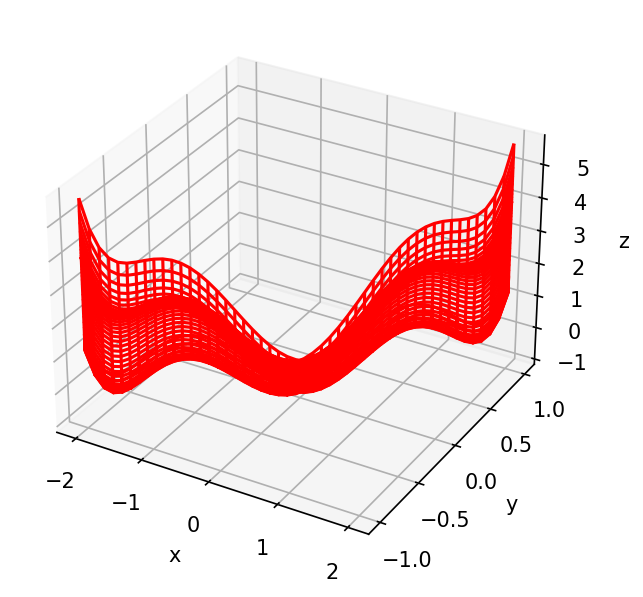

In [3]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt 
# Function calculation
x = np.linspace(-2,2,num=50)
y = np.linspace(-1,1,num=50)

fig = plt.figure(dpi=150)
ax = plt.axes(projection="3d")

xx, yy = np.meshgrid(x, y)
z = fun(xx,yy)
ax.plot_wireframe(x, y, z, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.tight_layout()

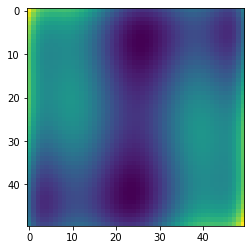

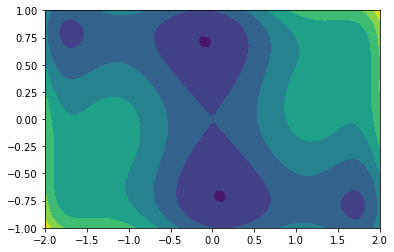

In [4]:
plt.imshow(z)
plt.figure()
plt.contourf(x, y, z)

In [8]:
from scipy import optimize
x0 = (0, 0) #initial guess
method_dict = {
    '1':'Nelder-Mead',
    '2':'Powell',
    '3':'CG',
    '4':'BFGS',
    '5':'Newton-CG',
    '6':'L-BFGS-B',
    '7':'TNC',
    '8':'COBYLA',
    '9':'SLSQP',
    '10':'trust-constr',
    '11':'dogleg',
    '12':'trust-ncg',
    '13':'trust-exact',
    '14':'trust-krylov'
}
for i in range(1,len(method_dict.keys())+1):
    try:
        method_tmp = method_dict.get(str(i)) 
        global_min = optimize.minimize(lambda x: fun(*x),x0, method=method_tmp) #remember that *x will give you all function parameters as a tuple
        print("The method {} provided this solution {}".format(method_tmp,global_min.x))
    except ValueError:
        continue

The method Nelder-Mead provided this solution [-0.08985145  0.71266538]
The method Powell provided this solution [-0.08984201  0.71265634]
The method CG provided this solution [0. 0.]
The method BFGS provided this solution [0. 0.]
The method L-BFGS-B provided this solution [0. 0.]
The method TNC provided this solution [0. 0.]
The method COBYLA provided this solution [-0.08982442  0.71254663]
The method SLSQP provided this solution [0. 0.]
The method trust-constr provided this solution [-5.96046448e-08  5.96046448e-08]


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

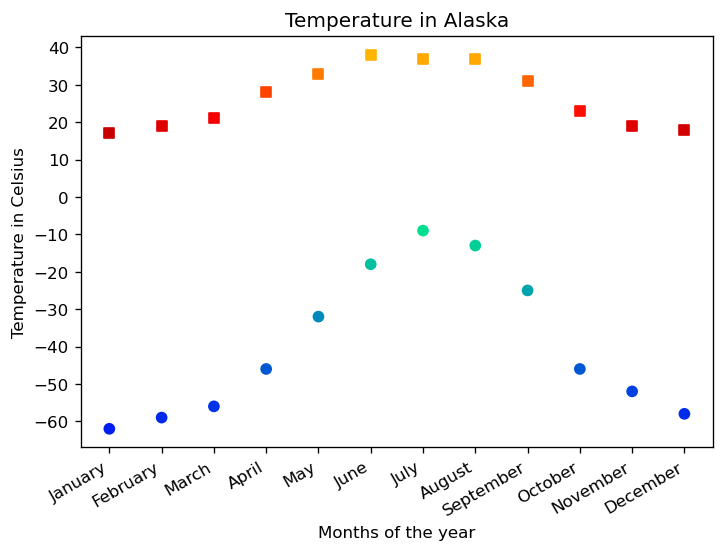

In [9]:
import calendar 
max_temp = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
min_temp = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

# Plot the temperature extremes
fig = plt.figure(dpi=120)
ax1 = fig.add_subplot(111)
# Plot settings
labels = [calendar.month_name[month_val] for month_val in range(1, 13)]
fig.tight_layout()
ax1.set_xticks(range(0,12))
ax1.set_yticks(range(-80,50,10))
ax1.set_xticklabels(labels)
ax1.set_title('Temperature in Alaska')
ax1.set_ylabel('Temperature in Celsius')
ax1.set_xlabel('Months of the year')
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

sc = ax1.scatter(range(0,len(max_temp)), max_temp, marker="s", c=max_temp, vmin=0, vmax=60, label='Max temperature',cmap='hot')
sc1 = ax1.scatter(range(0,len(min_temp)), min_temp, marker="o", c=min_temp, vmin=-70, vmax=0, label='Min temperature', cmap='winter')

In [21]:
def gaussian(x, a, b, x0, sigma):
    return a + b*np.exp( -(x - x0)**2 / (2*sigma**2) )

months = range(1,len(min_temp)+1)

params_max, pcov_max = optimize.curve_fit(gaussian, months, max_temp)
params_min, pcov_min = optimize.curve_fit(gaussian, months, min_temp)

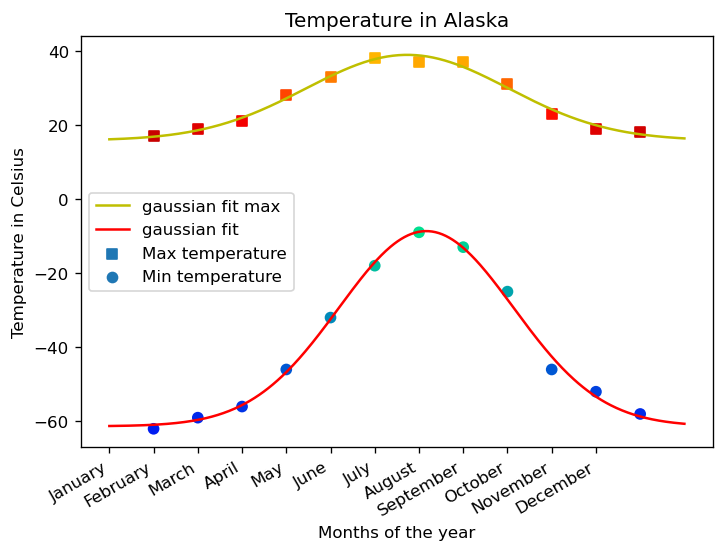

In [24]:
x = np.linspace(0, 13, 500)
fig = plt.figure(dpi=120)
ax1 = fig.add_subplot(111)
# Plot settings
labels = [calendar.month_name[month_val] for month_val in range(1, 13)]
fig.tight_layout()
ax1.set_xticks(range(0,12))
#ax1.set_yticks(range(-80,50,10))
ax1.set_xticklabels(labels)
ax1.set_title('Temperature in Alaska')
ax1.set_ylabel('Temperature in Celsius')
ax1.set_xlabel('Months of the year')
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

sc = ax1.scatter(range(1,len(max_temp)+1), max_temp, marker="s", c=max_temp, vmin=0, vmax=60, label='Max temperature',cmap='hot')
ax1.plot(x,gaussian(x, *params_max), "y-", label="gaussian fit max")
sc1 = ax1.scatter(range(1,len(min_temp)+1), min_temp, marker="o", c=min_temp, vmin=-70, vmax=0, label='Min temperature', cmap='winter')
ax1.plot(x,gaussian(x, *params_min), "r-", label="gaussian fit")
plt.legend()

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [25]:
import pandas as pd
file = "./data/residuals_261.pkl"
df = pd.DataFrame(pd.read_pickle(file).item())
df = df[abs(df["residuals"]) < 2]
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


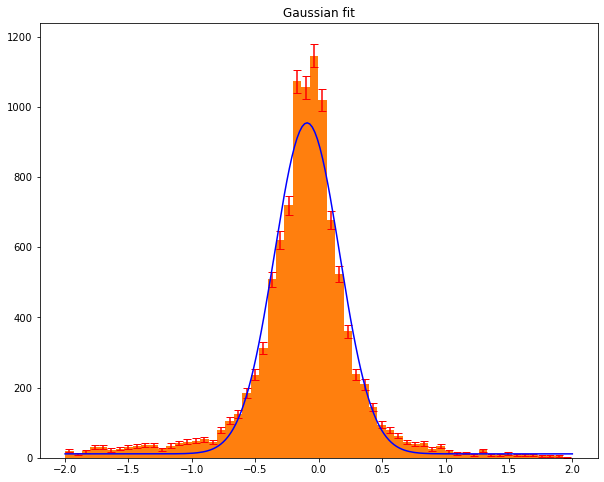

In [46]:
residuals = df["residuals"]
# plot the histogram
fig, ax = plt.subplots(figsize=(10, 8))
h, bins, _ = ax.hist(residuals, bins=60)

# plot the Poisson uncertainties
centers = .5*(bins[:-1] + bins[1:])
poisson_err = np.sqrt(abs(h))

ax.errorbar(centers, h, yerr=poisson_err, color='r', fmt='.', ms=0, capsize=4)

x = np.linspace(-2, 2, 200)
params, cov = optimize.curve_fit(gaussian, centers, h, sigma=poisson_err)
ax.plot(x, gaussian(x, *params), 'b-', label='gaussian fit')
ax.hist(residuals, bins = 60)
ax.set_title("Gaussian fit")
plt.show()

In [51]:
from scipy import stats
ndof = len(centers) - 1
chi2 = np.sum(((h - gaussian(centers, *params))**2) / poisson_err)
print("chi2 =", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory
print("The p value is too small, so the fit is not satisfactory")

chi2 = 8025.346397328699
p-value = 0.0
The p value is too small, so the fit is not satisfactory


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [80]:
def func(x, a, b, c):
    return a * np.cos(2 * np.pi * x + b) +c

In [81]:
file_name = 'data/munich_temperatures_average_with_bad_data.txt'

data = pd.read_csv(file_name, sep=' ', header=None, names=['time', 'temp'])
data = data[(data['time'] >= 2008) & (data['time'] <= 2012)]

#plt.scatter(data['time'], data['temp'], s=5)
# there are some noisy samples

data = data[data['temp'] < 50] # filter out noisy measures

data

,time,temp
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6204,2011.98836,3.44444
6205,2011.99110,1.27778
6206,2011.99384,2.88889
6207,2011.99658,1.83333


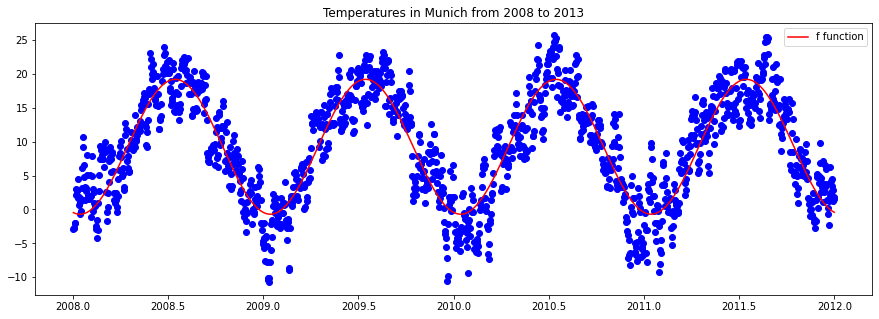

In [82]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data['time'],data['temp'], 'bo')
ax.set_title("Temperatures in Munich from 2008 to 2013")
params,_ = optimize.curve_fit(func, data['time'], data['temp'])
f_fit = func(data['time'],*params)
ax.plot(data['time'],f_fit,'r-', label="f function")
ax.legend()
plt.show()

In [83]:
print("All the following measures are based on the period from 2008 to 2013")
print(f"Overall average temperature in Munich: {data['temp'].mean():.1f}")
print(f"Coldest value predicted in the year: {max(f_fit):.1f}")
print(f"Hottest value predicted in the year: {min(f_fit):.1f}")
print("The b value is needed to move the function to one direction")

All the following measures are based on the period from 2008 to 2013
Overall average temperature in Munich: 9.3
Coldest value predicted in the year: 19.2
Hottest value predicted in the year: -0.7
The b value is needed to move the function to one direction


In [84]:
def func2(x, a, b, c, d):
    return a * np.cos(2 * np.pi * x * b + c) + d

In [85]:

# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL


In [89]:
params,cov = optimize.curve_fit(func, data['time'], data['temp'])
print('Fitted parameters:')
print(f'a = {params[0]:.2f} +- {np.sqrt(cov[0,0]):.2f}')
print(f'b = {params[1]:.2f} +- {np.sqrt(cov[1,1]):.2f}')
print(f'c = {params[2]:.2f} +- {np.sqrt(cov[2,2]):.2f}')
rss1 = np.sum((data["time"] - func(data["time"], *params))**2)
params,cov = optimize.curve_fit(func2, data['time'], data['temp'])
print('Fitted parameters:')
print(f'a = {params[0]:.2f} +- {np.sqrt(cov[0,0]):.2f}')
print(f'b = {params[1]:.2f} +- {np.sqrt(cov[1,1]):.2f}')
print(f'c = {params[2]:.2f} +- {np.sqrt(cov[2,2]):.2f}')
print(f'd = {params[3]:.2f} +- {np.sqrt(cov[3,3]):.2f}')
rss2 = np.sum((data["time"] - func2(data["time"], *params))**2)

Fitted parameters:
a = -9.96 +- 0.13
b = 12.33 +- 0.01
c = 9.26 +- 0.09
Fitted parameters:
a = -9.96 +- 0.13
b = 1.00 +- 0.00
c = 8.62 +- 23.79
d = 9.27 +- 0.10


In [87]:

print(f'RSS1 = {rss1:.1f}')
print(f'RSS2 = {rss2:.1f}')
cl_1_vs_2 = Ftest(rss1, rss2, 2, 3, len(data["time"]), verbose=True)

RSS1 = 5840395473.5
RSS2 = 5840395473.5
CL: 1.000 , additional parameter necessary: NO
